In [1]:
import scipy.optimize
from itertools import cycle
import seaborn as sns
import multihist as mh
import datetime
import numba
import sys
import os
import scipy
import pandas as pd
import wimprates as wr
import numericalunits as nu
from tqdm import tqdm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import time
import dddm
dddm.print_versions()

Host DESKTOP-F4PI41P.
   module version                                                                      path                                   git
   python  3.10.4                             /home/joran/miniconda3/envs/py3.10/bin/python                                  None
     dddm   3.0.2                                            /home/joran/software/dddm/dddm branch:test_nb_and_drak_elf | 92cd65a
    numpy  1.21.5     /home/joran/miniconda3/envs/py3.10/lib/python3.10/site-packages/numpy                                  None
    numba  0.55.1     /home/joran/miniconda3/envs/py3.10/lib/python3.10/site-packages/numba                                  None
wimprates   0.3.2 /home/joran/miniconda3/envs/py3.10/lib/python3.10/site-packages/wimprates                                  None


,module,version,path,git
0,python,3.10.4,/home/joran/miniconda3/envs/py3.10/bin/python,None
1,dddm,3.0.2,/home/joran/software/dddm/dddm,branch:test_nb_and_drak_elf | 92cd65a
2,numpy,1.21.5,/home/joran/miniconda3/envs/py3.10/lib/python3...,None
3,numba,0.55.1,/home/joran/miniconda3/envs/py3.10/lib/python3...,None
4,wimprates,0.3.2,/home/joran/miniconda3/envs/py3.10/lib/python3...,None


# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

## HALO model ##



/home/joran/miniconda3/envs/py3.10/lib/python3.10/site-packages/wimprates/halo.py:143: RuntimeWarning: divide by zero encountered in true_divide
  (v_esc**2 - v_earth_t**2 - v**2)


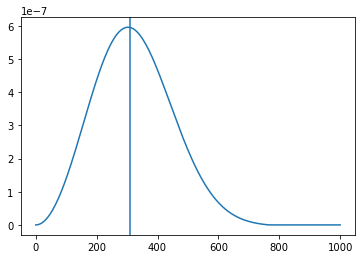

In [2]:
x = np.linspace(0,1000,200) * nu.km / nu.s
y2 = wr.observed_speed_dist(x, 0)
plt.plot(x/(nu.km / nu.s),y2)
plt.axvline(310)

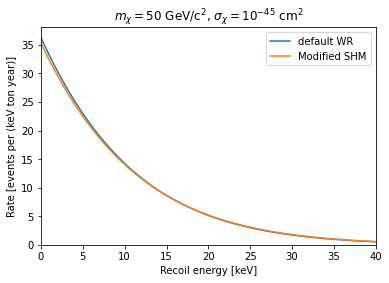

In [3]:
# NR's
energies = np.linspace(0.001, 40, 100)

# dr/dr
dr = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45)

plt.plot(energies, dr, label='default WR')

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 50$ GeV/c${}^2$, $\sigma_\chi = 10^{-45}$ cm${}^2$")
plt.xlim(0, energies.max())
plt.ylim(0, None)

use_SHM = dddm.SHM()
dr_shm = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45, halo_model = use_SHM)
plt.plot(energies, dr_shm, label = "Modified SHM")
plt.legend()

2022-07-21 12:09:59.683536 | Shielded |INFO     | load_f (L96)         | load_f::	write to ./verne_files/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/sig_-35.0_mx_0.00_avg.csv (True). Then copy to ./verne_files/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/sig_-35.0_mx_0.00_avg_temp_5809.csv
2022-07-21 12:09:59.684937 | Shielded |INFO     | load_f (L101)        | Using ./verne_files/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/sig_-35.0_mx_0.00_avg.csv for the velocity distribution. Writing to ./verne_files/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/sig_-35.0_mx_0.00_avg_temp_5809.csv
    Loading isotope data and density profiles...
    Calculating Form Factor corrections for m_x =  1.0  GeV...
2022-07-21 12:11:43.606763 | Shielded |INFO     | load_f (L113)        | writing to ./verne_files/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/sig_-35.0_mx_0.00_avg_temp_5809.csv
2022-07-21 12:11:43.613332 | Shielded |INFO     | load_f (L116)        | moving ./verne_files/f_params/loc_XENON/v0_

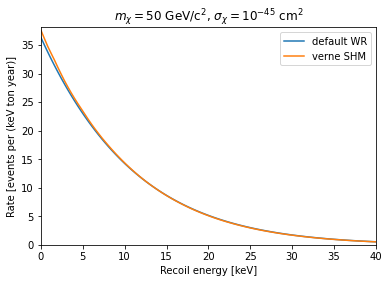

In [4]:
# NR's
energies = np.linspace(0.0001, 40, 100)

# dr/dr
dr = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45)

plt.plot(energies, dr, label='default WR')


plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 50$ GeV/c${}^2$, $\sigma_\chi = 10^{-45}$ cm${}^2$")
plt.xlim(0, energies.max())
plt.ylim(0, None)

try: 
    import verne
except (ImportError, ModuleNotFoundError):
    pass
else:
    use_SHM = dddm.ShieldedSHM(location='XENON')
    dr_shm = wr.rate_wimp_std(energies,
        mw=50, sigma_nucleon=1e-45, halo_model = use_SHM)
    plt.plot(energies, dr_shm, label = "verne SHM")
    plt.legend()

In [5]:
# NR's
energies = np.linspace(0.1, 10, 100)

# dr/dr
dr = wr.rate_migdal(energies* nu.keV, 
                    mw=5 * nu.GeV / nu.c0 ** 2, 
                    material='Ge',
                    sigma_nucleon=1e-40 * nu.cm ** 2) * (nu.keV * (1000 * nu.kg) * nu.year)
# dr = wr.rate_wimp_std(energies, mw=5, sigma_nucleon=1e-40, material='Ge')

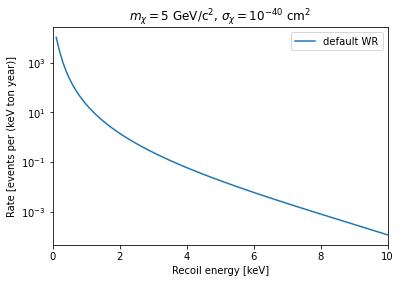

In [6]:
plt.plot(energies, dr, label='default WR')


plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 5$ GeV/c${}^2$, $\sigma_\chi = 10^{-40}$ cm${}^2$")
plt.xlim(0, energies.max())
# plt.ylim(0, dr.max());

plt.yscale('log')
plt.legend()